Aggregated Results (Averages):
          R^2           MSE      RMSE       MAE          MAPE  \
0    0.973401  1.704744e-02  0.127000  0.050916  6.158377e-03   
1    0.552642  4.628631e+00  2.150825  1.523289  1.512075e-01   
2   -0.403219  2.356149e-07  0.000463  0.000317  2.333651e+08   
3    0.447314  4.255934e-01  0.650822  0.348675  1.034948e+14   
4    0.934709  4.179695e-02  0.199723  0.138445  1.673985e-02   
..        ...           ...       ...       ...           ...   
116  0.688537  1.007325e-01  0.317249  0.236369  1.946790e-02   
117  0.354308  2.928362e-05  0.004716  0.002982  1.353553e-01   
118  0.944337  5.724072e-02  0.239242  0.188256  2.437929e-02   
119  0.344358  4.997470e-01  0.706590  0.548864  9.740437e-02   
120  0.887714  5.064919e-06  0.002243  0.001611  7.486551e-02   

              dataset          model  
0    Brazilian_houses  tabautopnpnet  
1             abalone    tabbaseline  
2            Ailerons     autopnpnet  
3           house_16H    tabbase

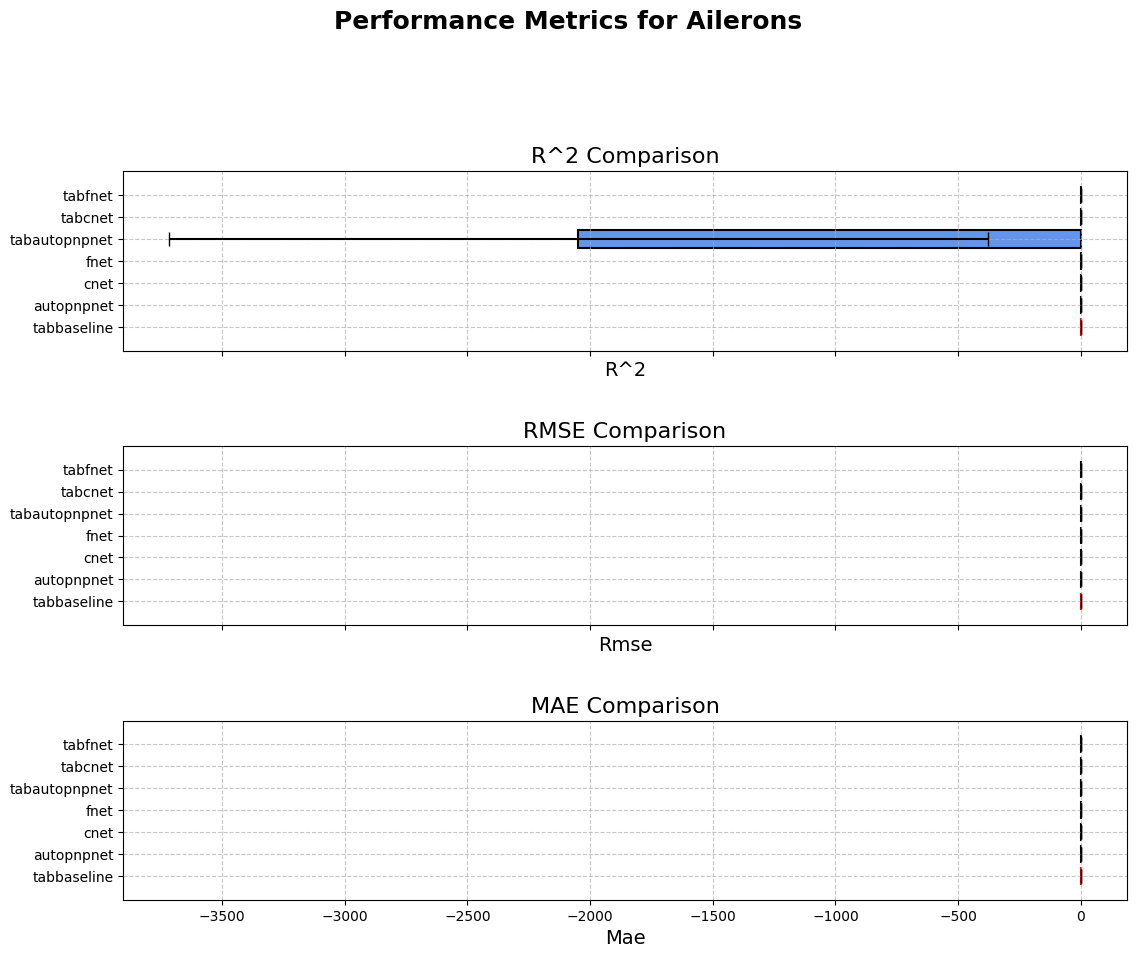

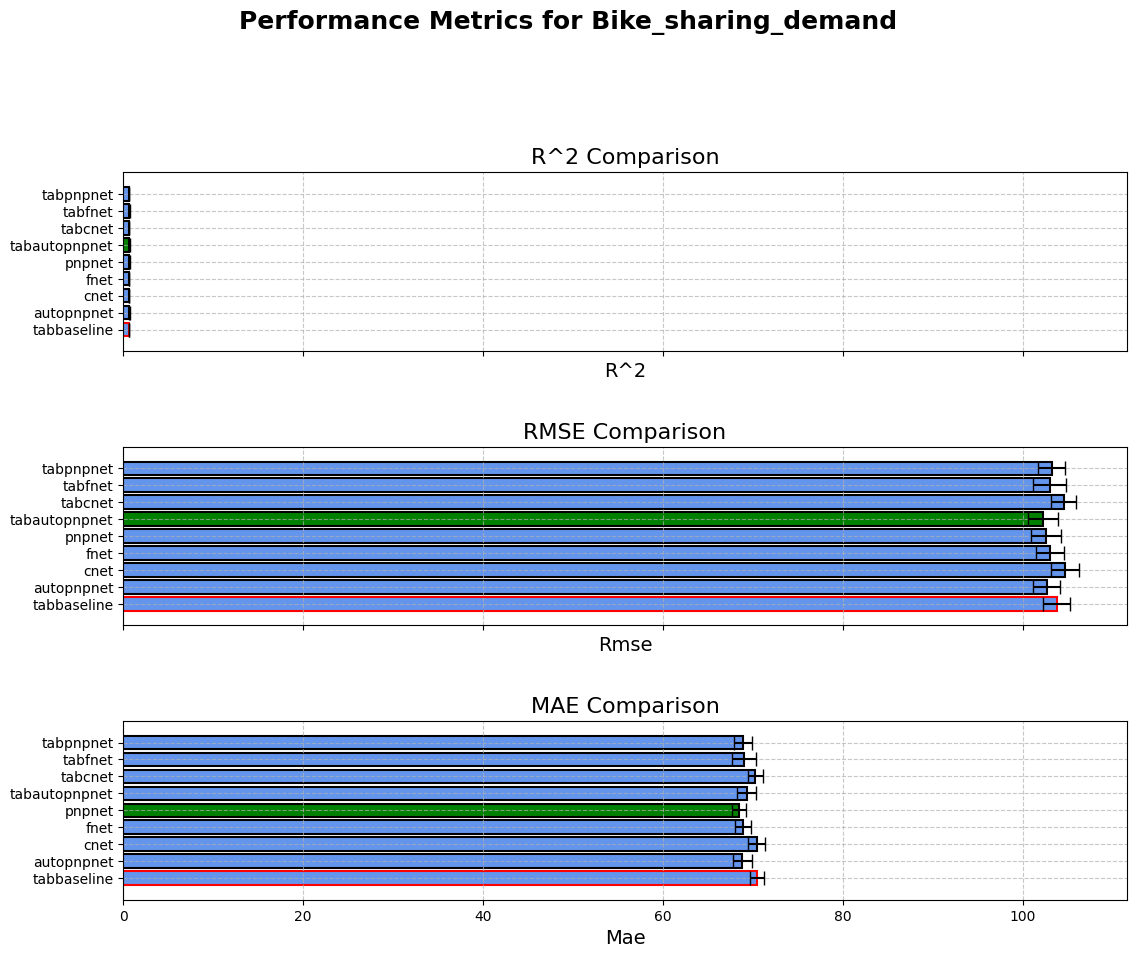

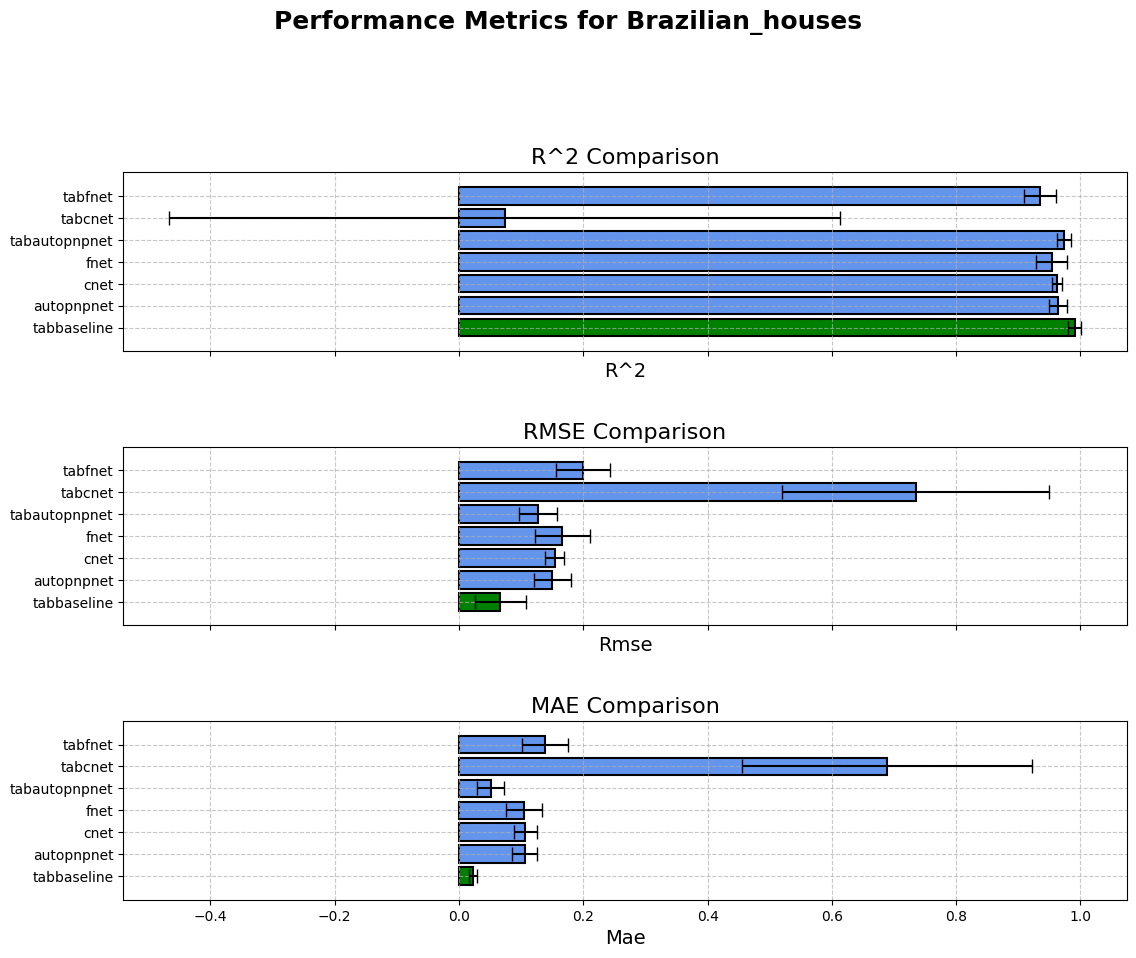

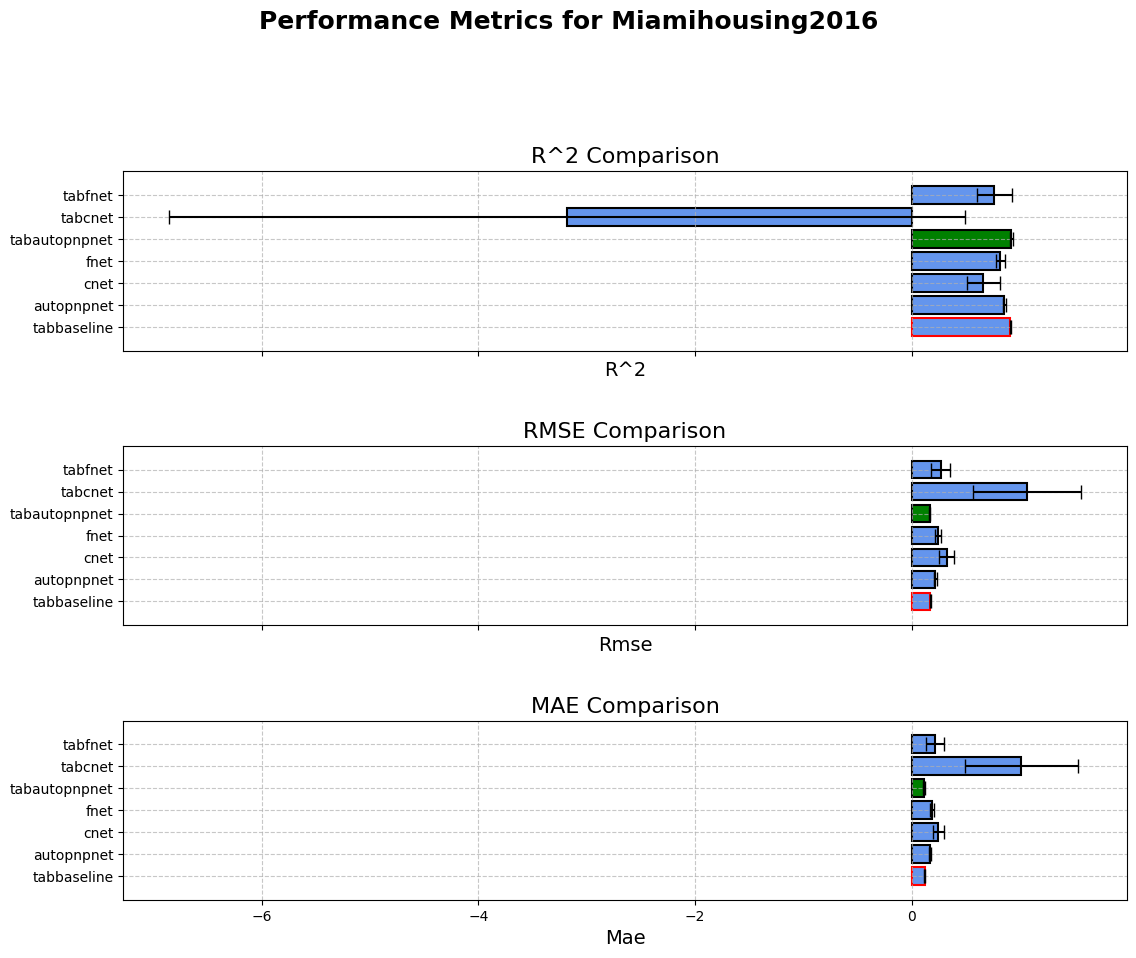

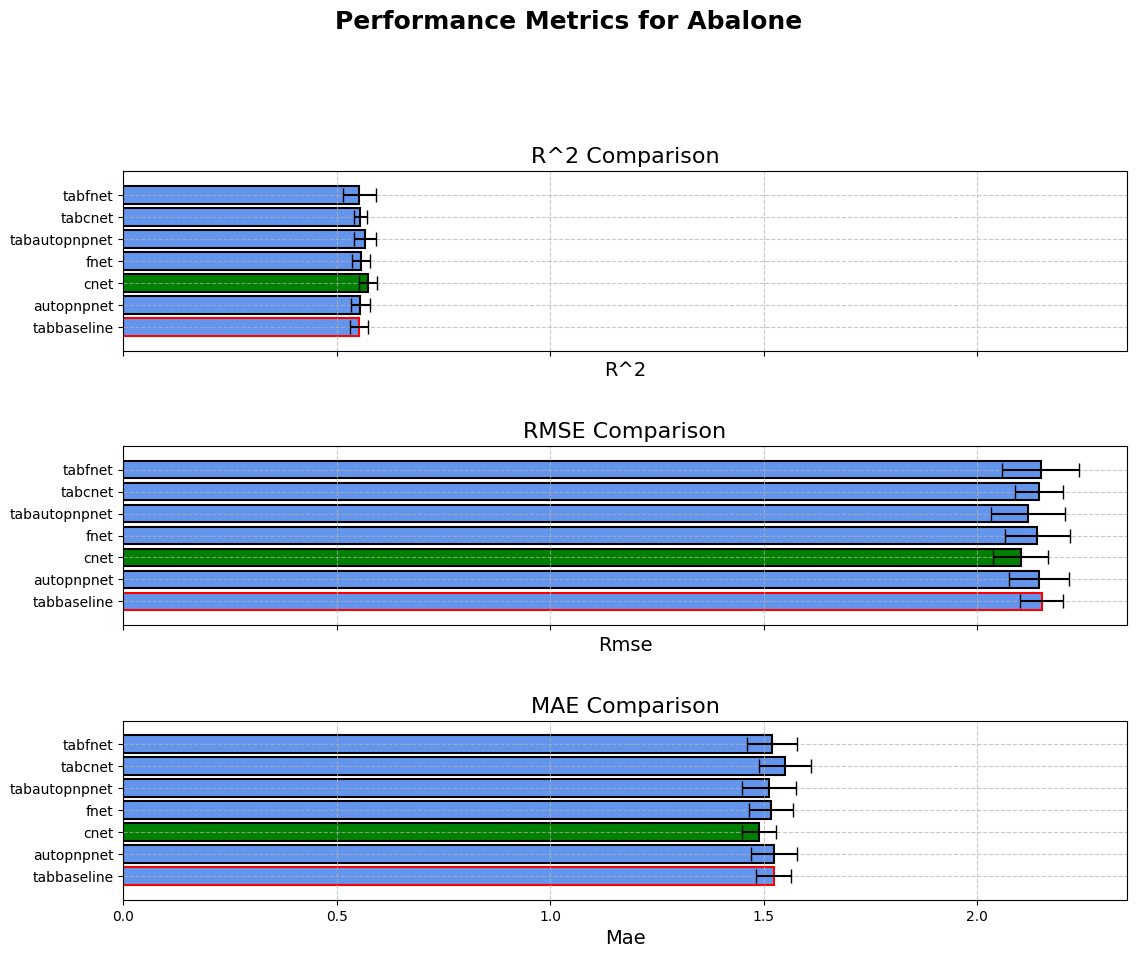

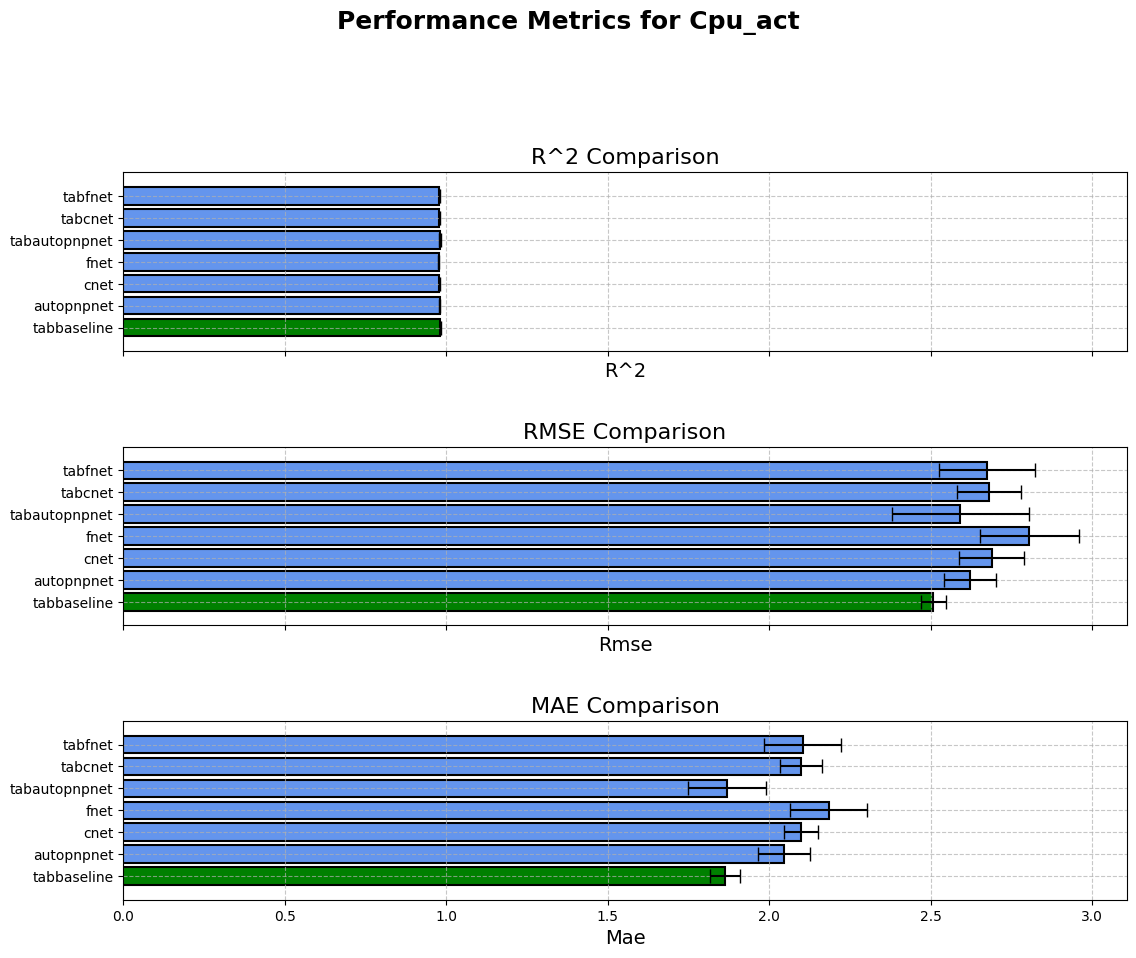

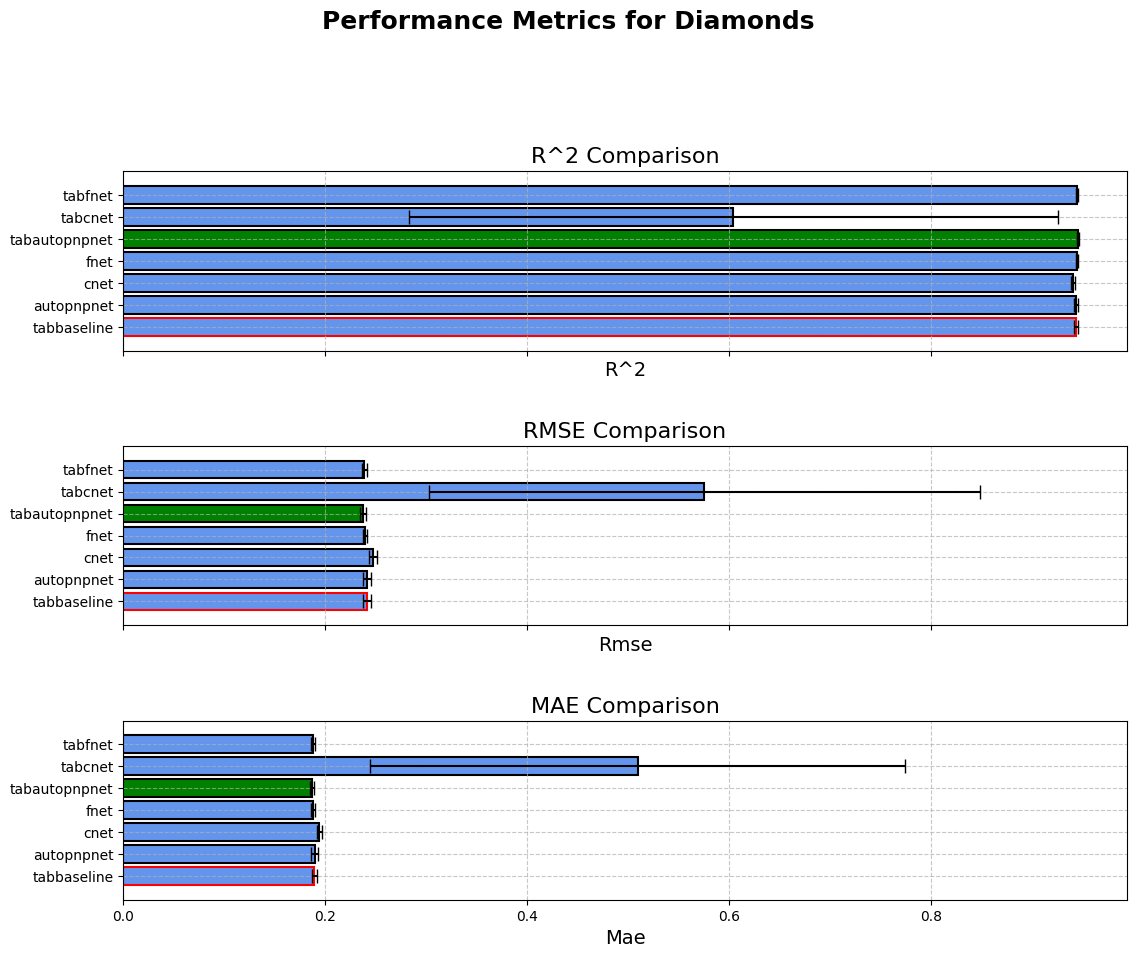

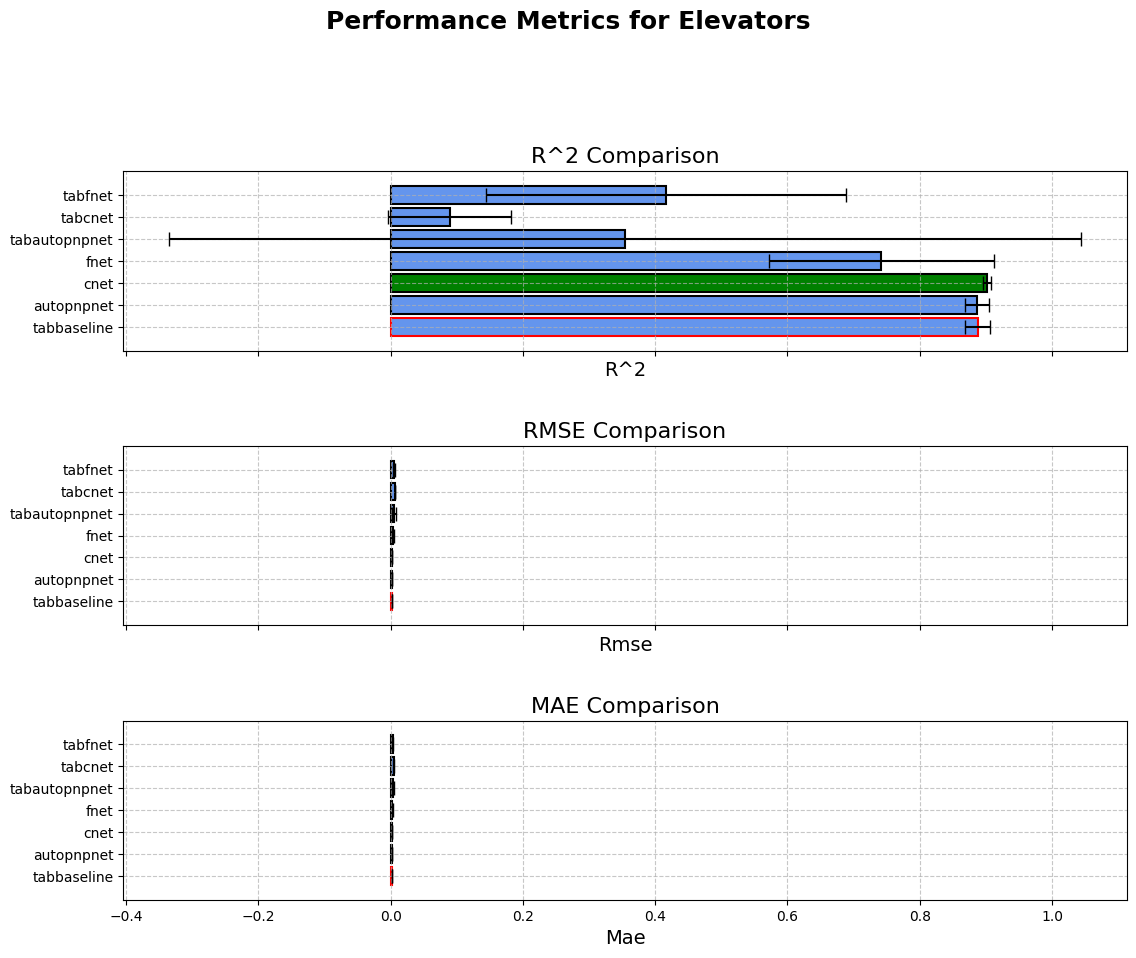

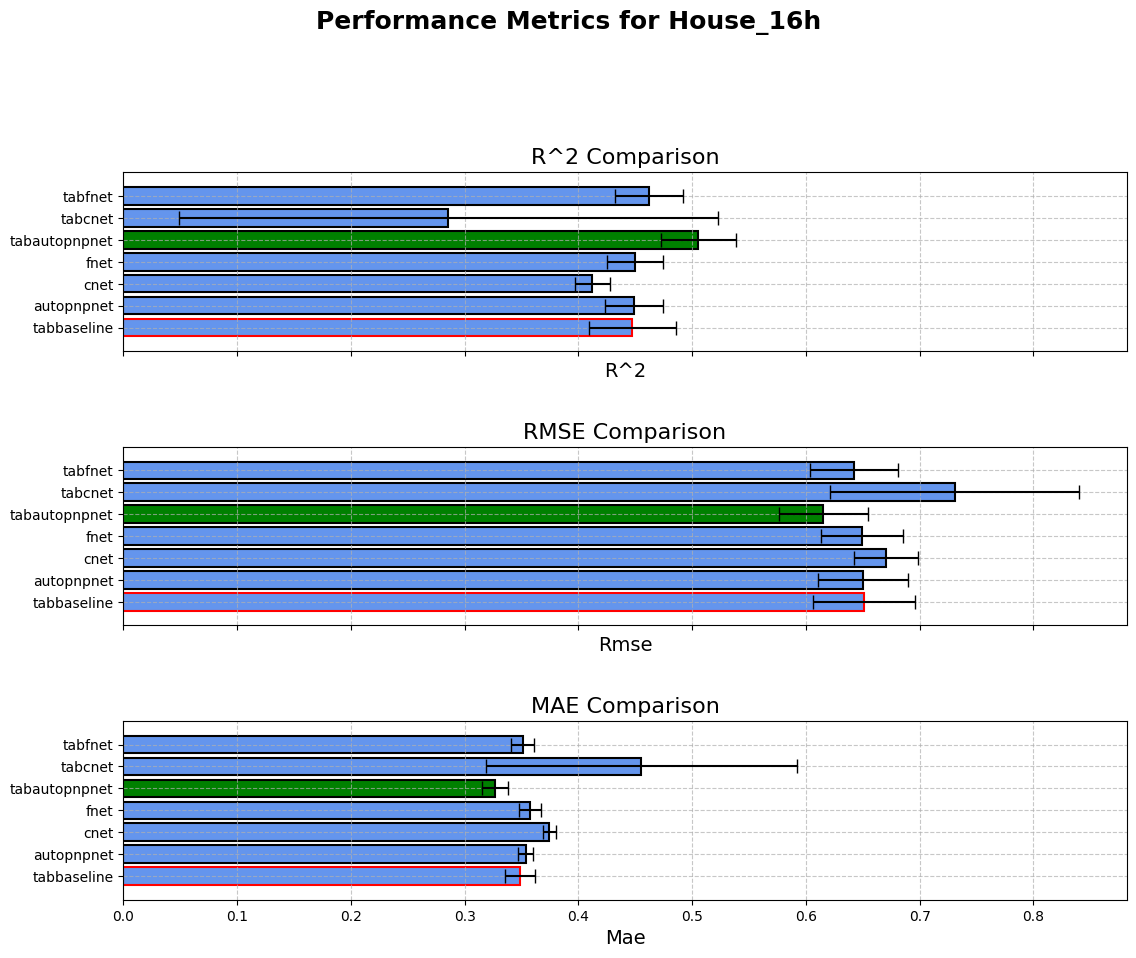

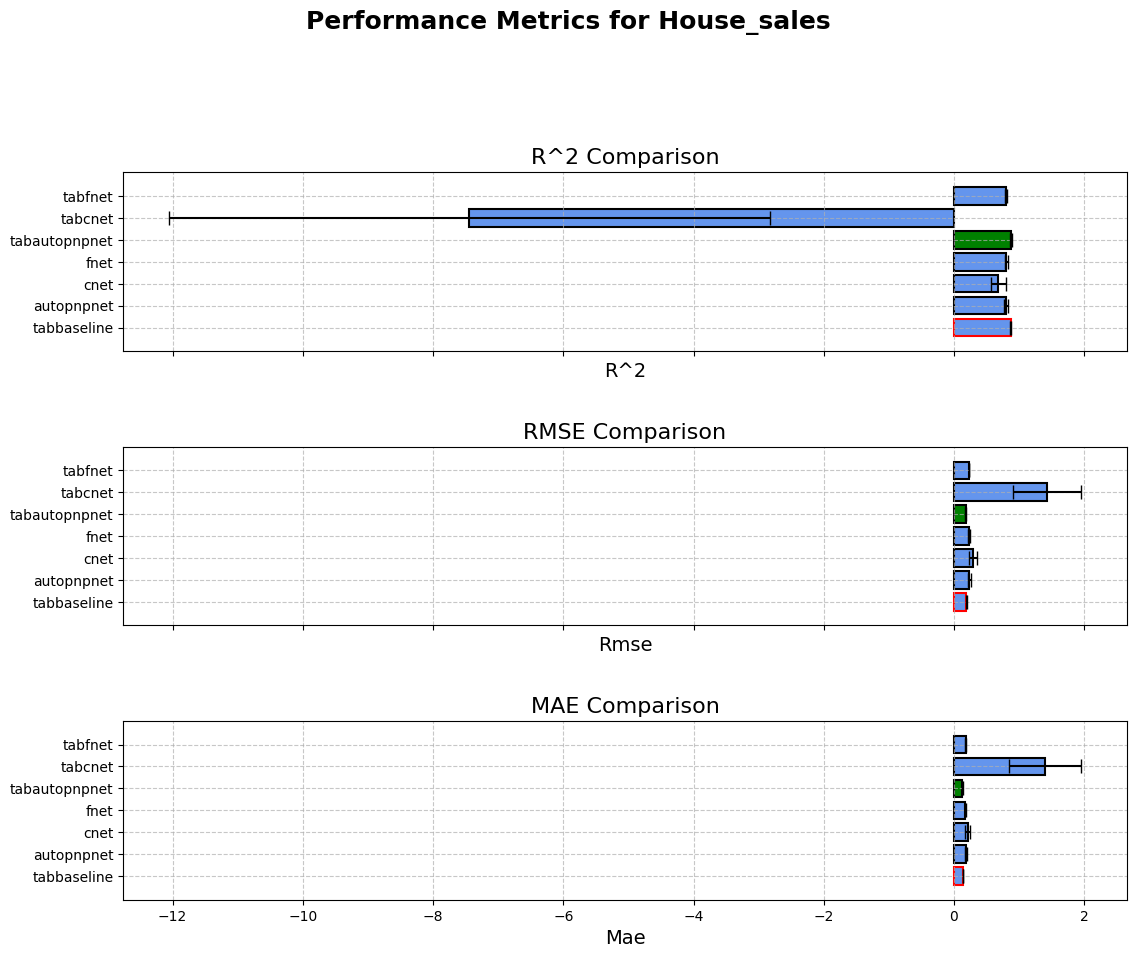

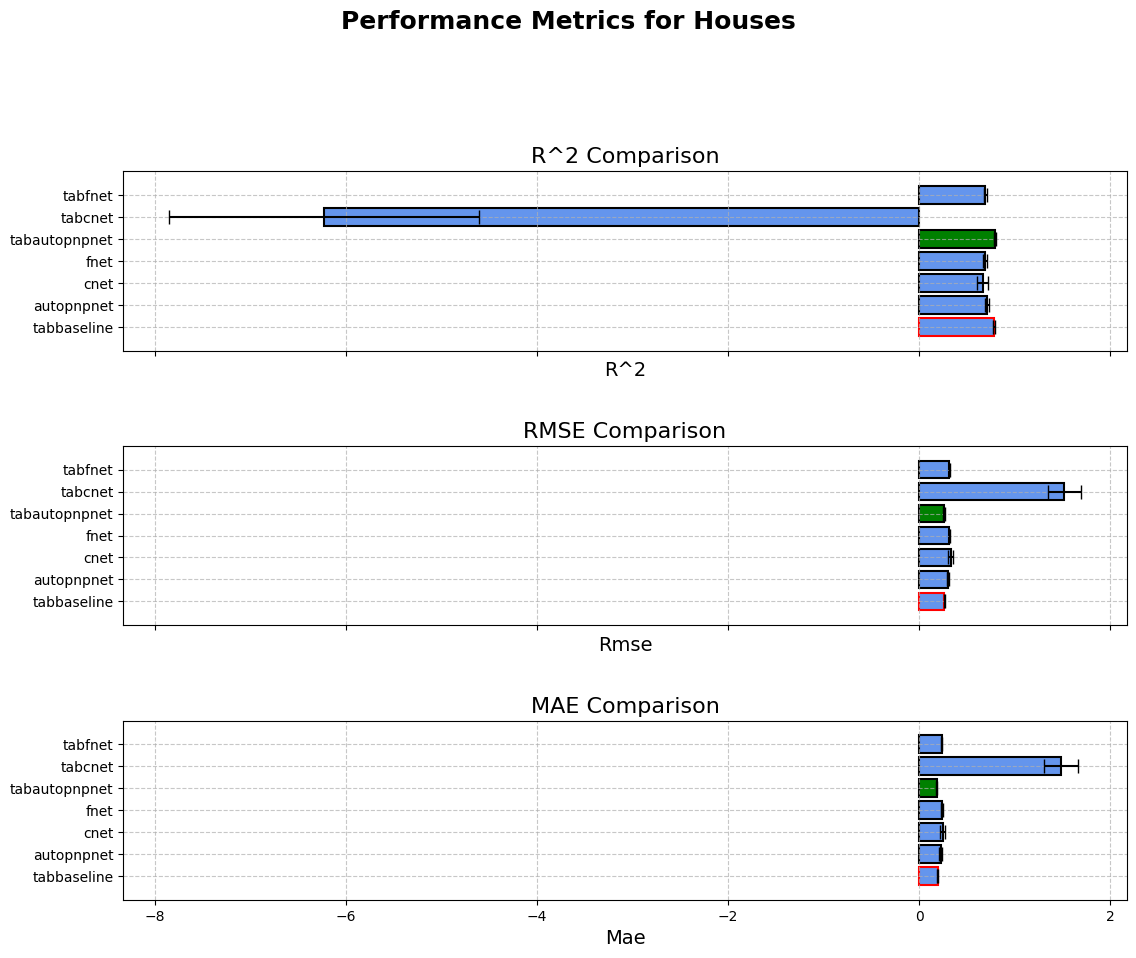

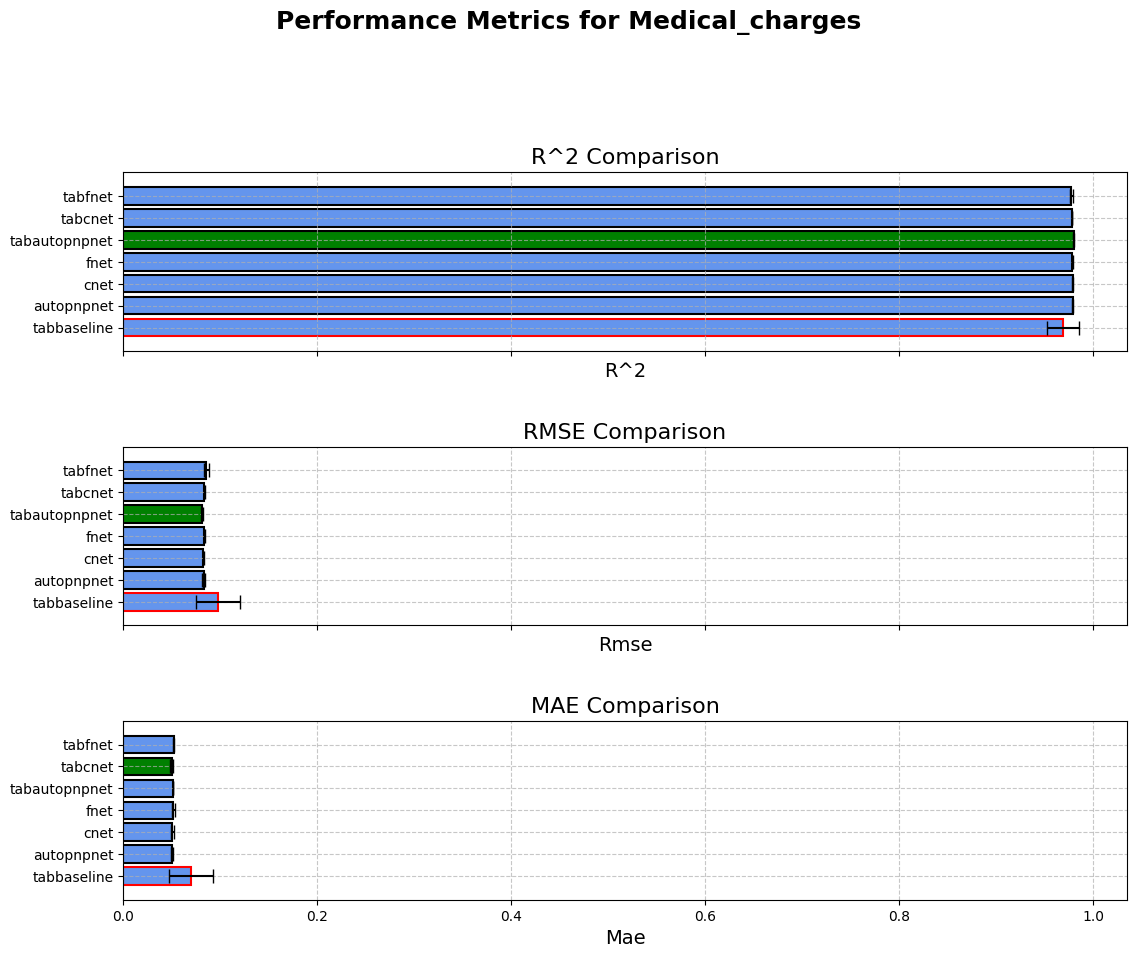

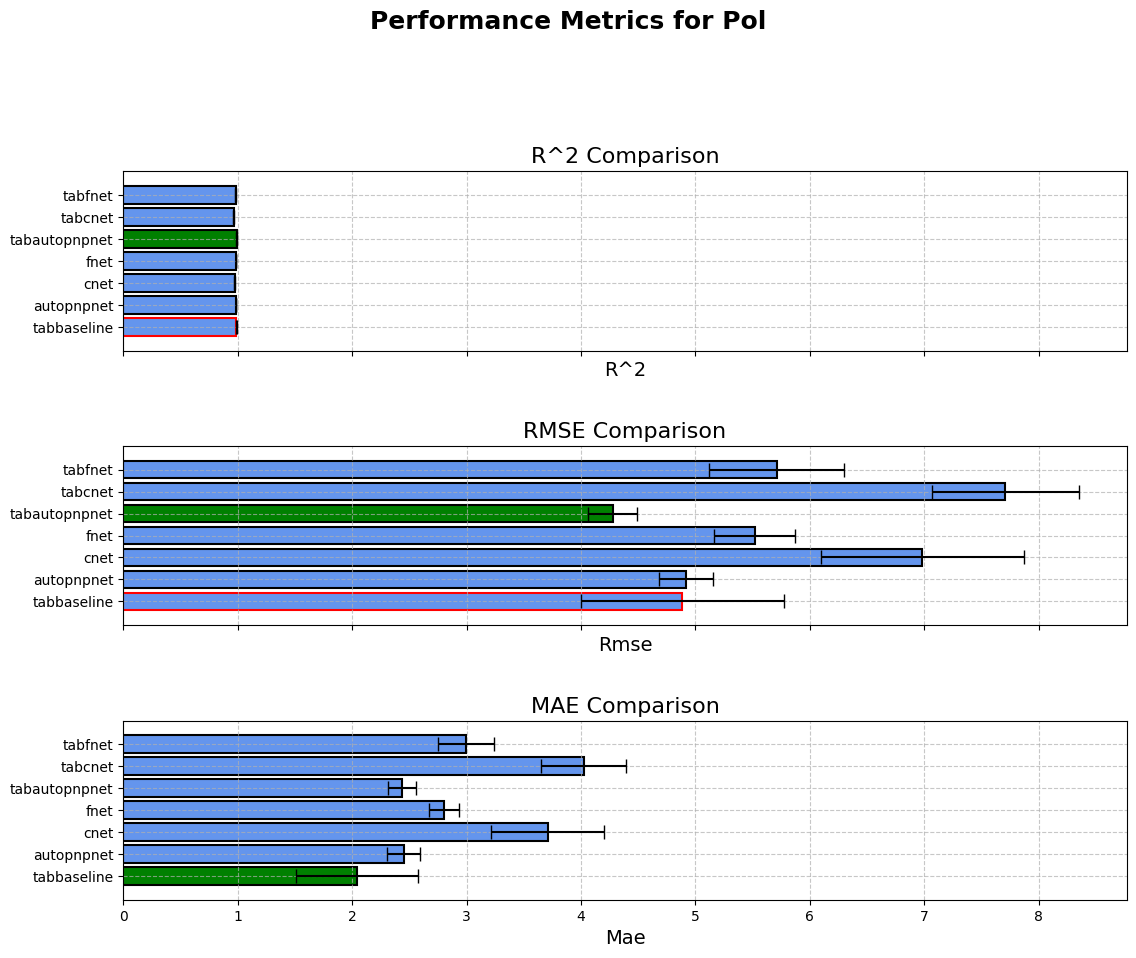

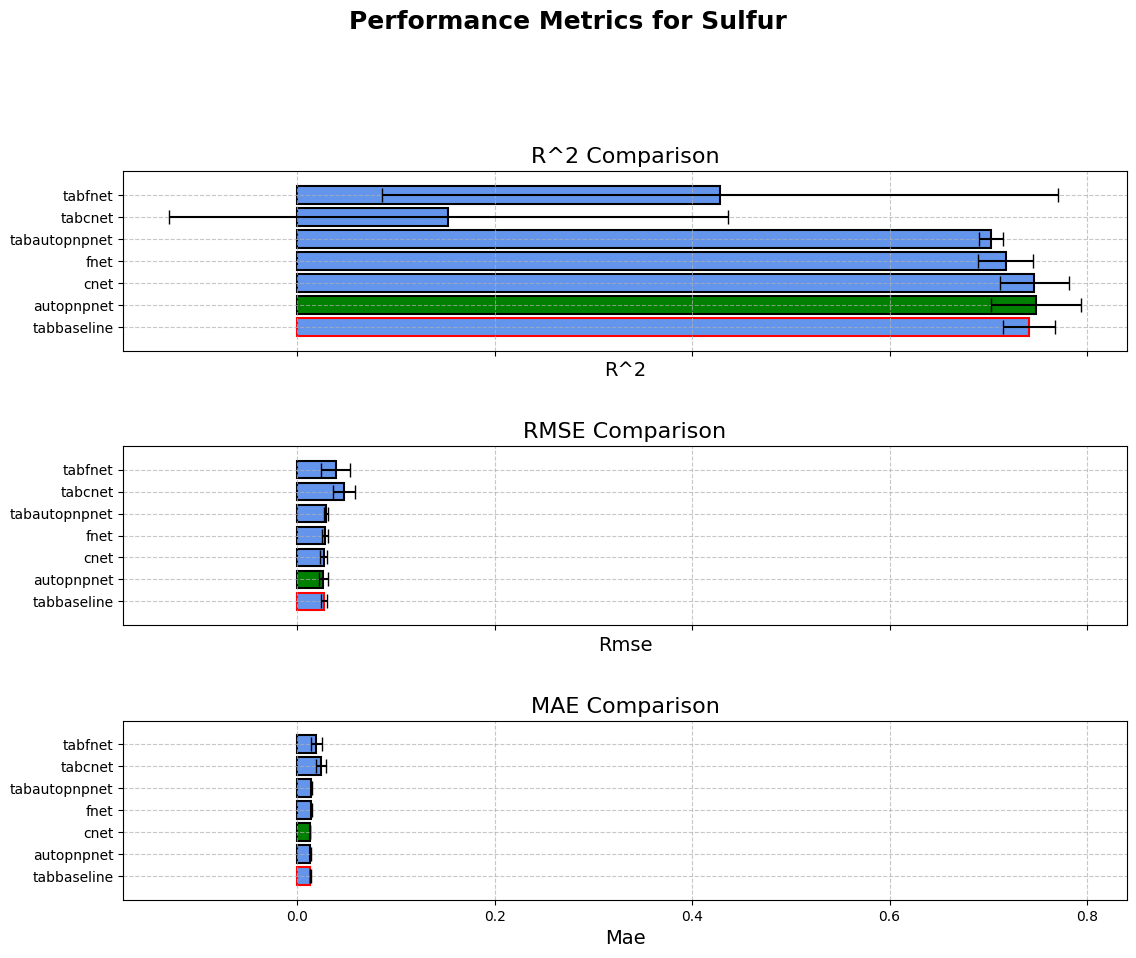

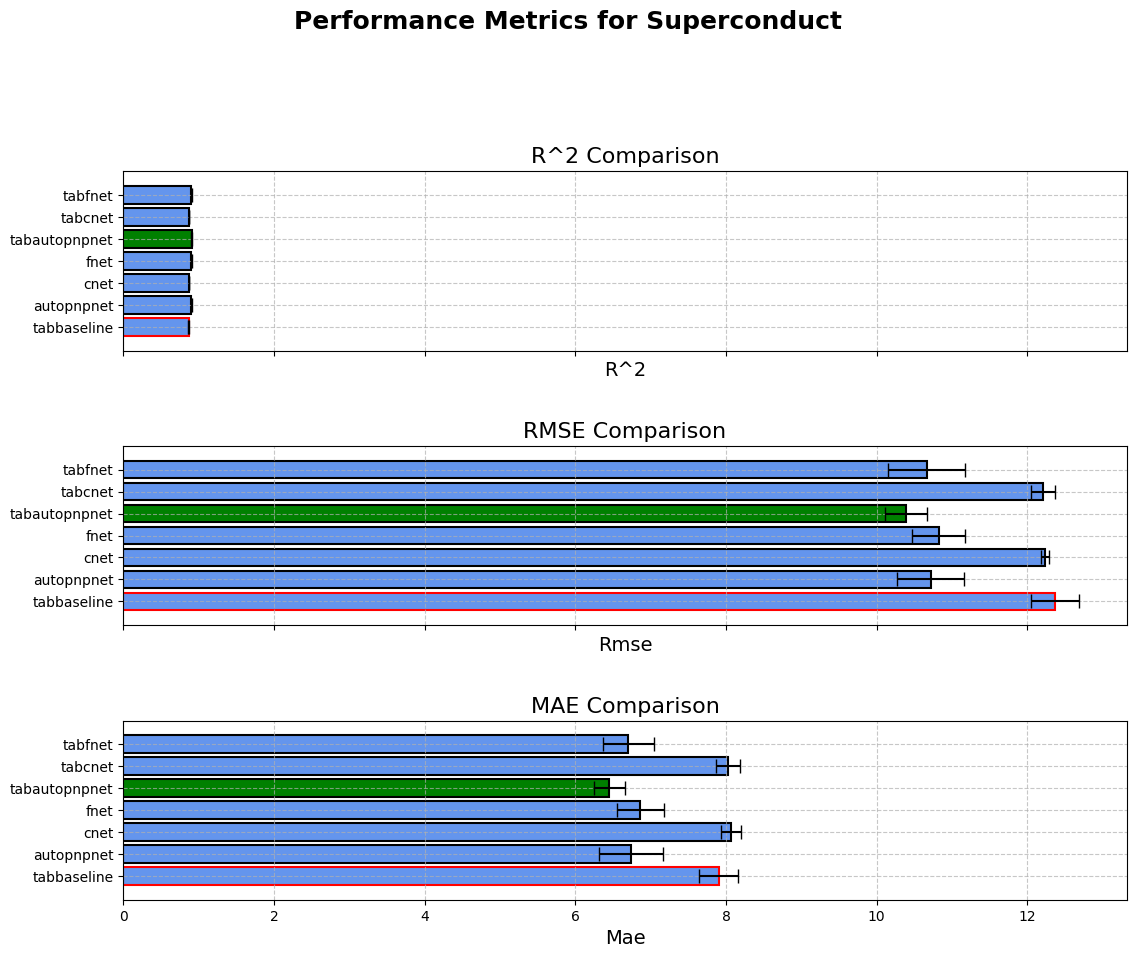

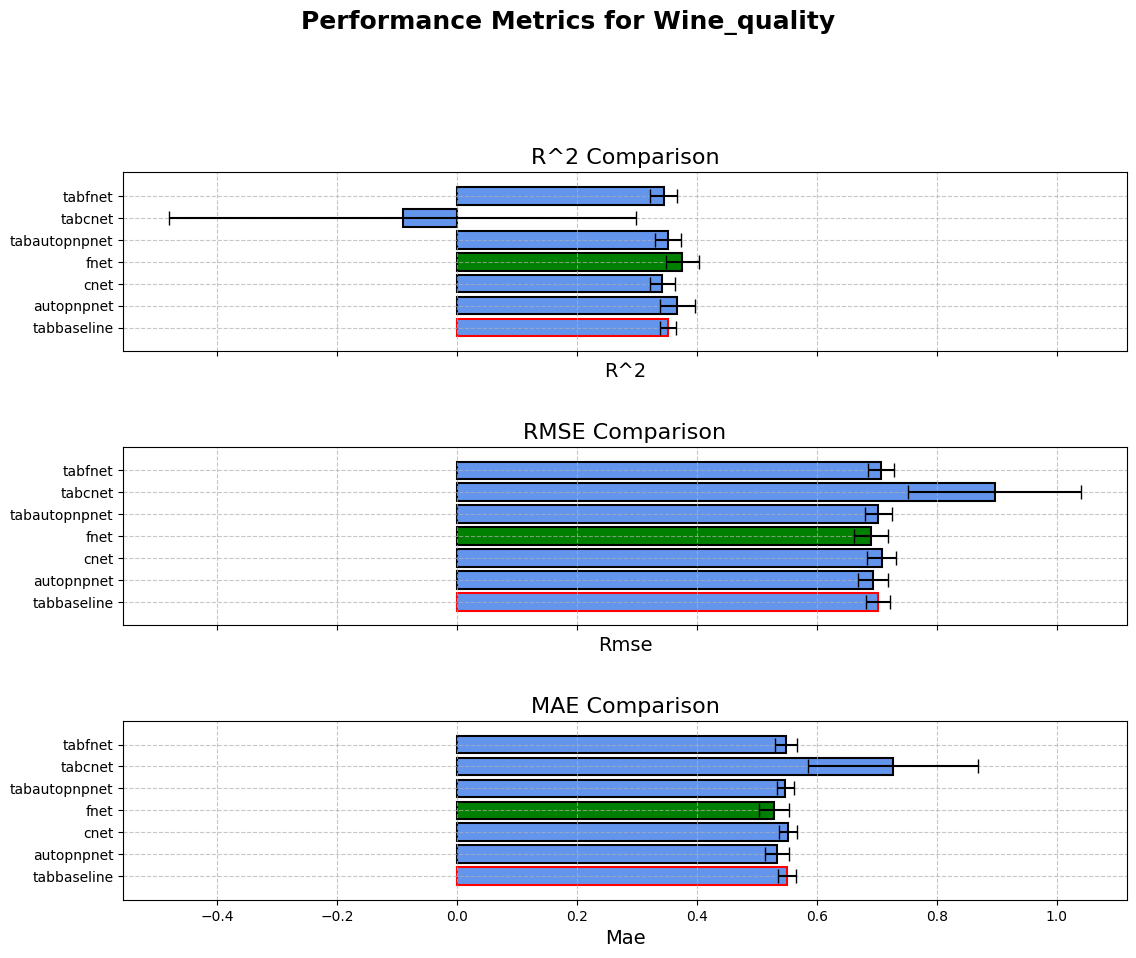

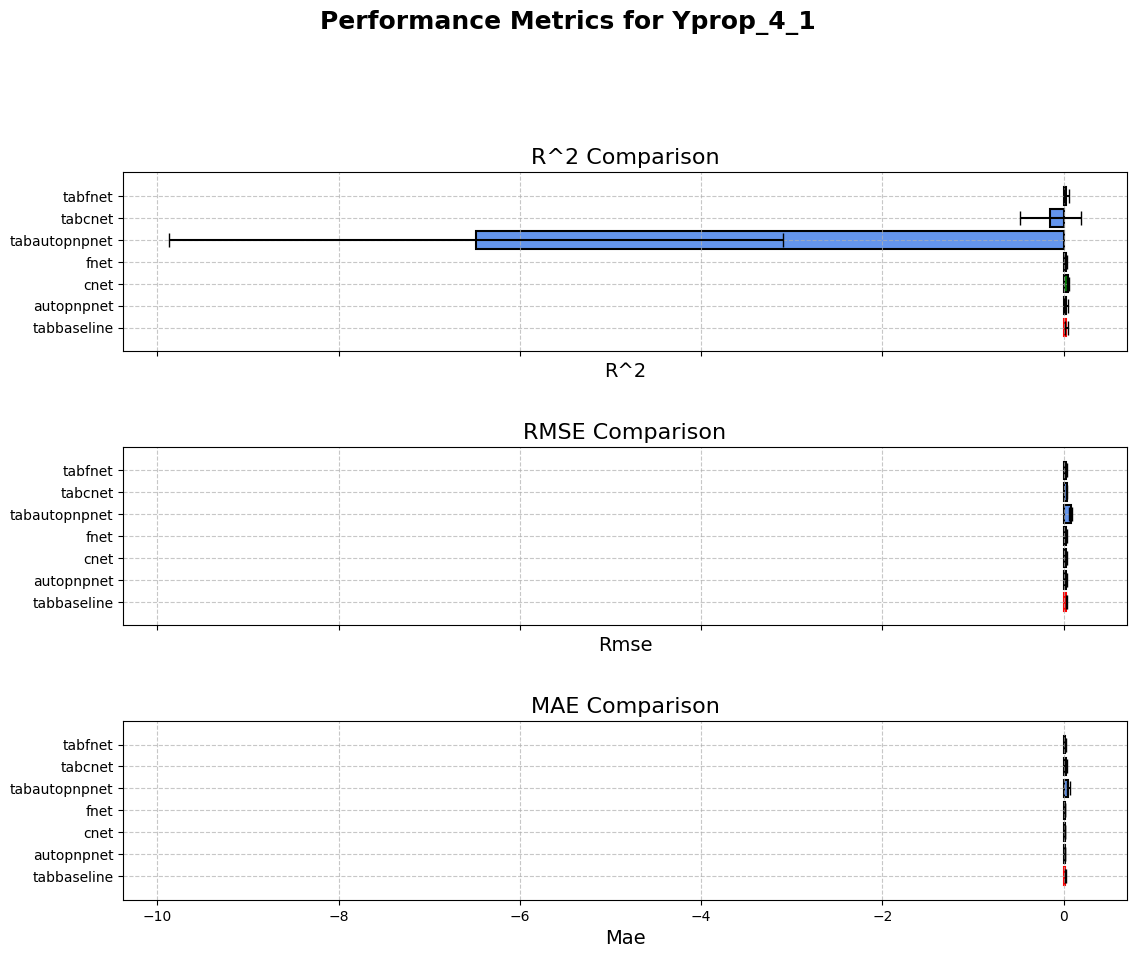

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Define the path to the directory containing experiment logs
log_dir = "../results/benchmark_num_reg"

def load_metrics(json_path):
    """Load and return metrics from a JSON file."""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {json_path}: {e}")
        return {}

def aggregate_metrics(log_dir):
    """Aggregate metrics from all experiment folders."""
    summary = []
    
    for dataset_model_folder in glob(f"{log_dir}/*__*"):
        dataset, model = os.path.basename(dataset_model_folder).split("__", 1)
        model = model.split("_")[0]
        
        fold_metrics = [
            load_metrics(metrics_file) for metrics_file in glob(f"{dataset_model_folder}/*_metrics.json")
            if isinstance(load_metrics(metrics_file), dict)
        ]

        if fold_metrics:
            metrics_df = pd.DataFrame(fold_metrics)
            avg_metrics = metrics_df.mean().to_dict()
            std_metrics = metrics_df.std().to_dict()
            avg_metrics.update({"dataset": dataset, "model": model})
            std_metrics.update({"dataset": dataset, "model": model})
            summary.append((avg_metrics, std_metrics))

    avg_summary_df = pd.DataFrame([s[0] for s in summary])
    std_summary_df = pd.DataFrame([s[1] for s in summary])
    return avg_summary_df, std_summary_df

def calculate_percentage_improvement(best_value, baseline_value, metric):
    """Calculate percentage improvement relative to baseline."""
    if metric == "R^2":
        # For R^2, higher is better
        return ((best_value - baseline_value) / abs(baseline_value)) * 100 if baseline_value != 0 else None
    else:
        # For RMSE and MAE, lower is better
        return ((baseline_value - best_value) / abs(baseline_value)) * 100 if baseline_value != 0 else None

def print_percentage_improvements(avg_summary_df, metrics=["R^2", "RMSE", "MAE"], baseline_model="tabbaseline"):
    """Print percentage improvements for each top-performing model relative to baseline."""
    for dataset, data in avg_summary_df.groupby("dataset"):
        baseline_row = data[data["model"] == baseline_model]
        if baseline_row.empty:
            print(f"No baseline model data for dataset {dataset}")
            continue

        print(f"\nDataset: {dataset}")
        for metric in metrics:
            baseline_value = baseline_row[metric].values[0]
            if metric == "R^2":
                best_row = data.loc[data[metric].idxmax()]
            else:
                best_row = data.loc[data[metric].idxmin()]
            
            best_model = best_row["model"]
            best_value = best_row[metric]
            
            if best_model != baseline_model:
                improvement = calculate_percentage_improvement(best_value, baseline_value, metric)
                print(f"  {metric} - {best_model} improvement over {baseline_model}: {improvement:.2f}%")

def get_colors_and_edges_for_models(models, values, best_idx, highlight_model="tabbaseline"):
    """Assign fill colors and edge colors for each model."""
    colors = []
    edges = []
    
    for idx, model in enumerate(models):
        if idx == best_idx:
            colors.append('green')  # Highlight best model with green fill
            edges.append('black')
        elif model == highlight_model:
            colors.append('cornflowerblue')  # Regular color for "tabbaseline" fill
            edges.append('red')  # Red edges for "tabbaseline"
        else:
            colors.append('cornflowerblue')
            edges.append('black')
    
    return colors, edges

def plot_metrics_per_dataset(avg_summary_df, std_summary_df):
    """Plot R^2, RMSE, and MAE metrics for each dataset."""
    metrics_to_plot = ["R^2", "RMSE", "MAE"]
    
    for dataset, data in avg_summary_df.groupby("dataset"):
        std_data = std_summary_df[std_summary_df["dataset"] == dataset]
        
        # Sort models, placing "tabbaseline" first, then alphabetically by other model names
        data = data.set_index("model")
        std_data = std_data.set_index("model")
        sorted_index = sorted(data.index, key=lambda x: (x != "tabbaseline", x))
        data = data.loc[sorted_index].reset_index()
        std_data = std_data.loc[sorted_index].reset_index()
        
        fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"Performance Metrics for {dataset.capitalize()}", fontsize=18, weight='bold')
        
        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i]
            values = data[metric]
            errors = std_data[metric]
            models = data["model"]
            
            # Identify the best model based on metric type
            best_idx = values.idxmax() if metric == "R^2" else values.idxmin()
            colors, edges = get_colors_and_edges_for_models(models, values, best_idx)

            ax.barh(models, values, xerr=errors, color=colors, edgecolor=edges, capsize=5, linewidth=1.5)
            ax.set_title(f"{metric.upper()} Comparison", fontsize=16)
            ax.set_xlabel(metric.capitalize(), fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.margins(y=0.1)
        
        plt.subplots_adjust(hspace=0.5)
        plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])
        plt.show()

# Run analysis
avg_summary_df, std_summary_df = aggregate_metrics(log_dir)
print("Aggregated Results (Averages):")
print(avg_summary_df)

# Print percentage improvements of top-performing models over the baseline
print("Percentage improvements of top-performing models relative to the baseline:")
print_percentage_improvements(avg_summary_df)

# Save summary to CSV
avg_summary_df.to_csv("experiment_summary_avg.csv", index=False)

# Plot metrics for each dataset
plot_metrics_per_dataset(avg_summary_df, std_summary_df)